In [1]:
import math
import os
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib.ticker import LogLocator
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import BoundaryNorm
from brokenaxes import brokenaxes
import xarray as xr 
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import datetime 
import pytz
import csv
import seaborn as sns
from scipy.stats import kde
from scipy.stats import gaussian_kde
import plotly.express as px
from haversine import haversine
from cartopy.geodesic import Geodesic
import shapely.geometry as sgeom
import netCDF4
import xskillscore as xs
import geopandas as gpd
from scipy.interpolate import LinearNDInterpolator
from scipy.optimize import minimize
from scipy import stats
import rioxarray 
from mpl_toolkits.axes_grid1 import make_axes_locatable
proj = ccrs.PlateCarree()

#Plotting with h3 uber 
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from sklearn.preprocessing import RobustScaler
import h3

#Masking array
from rechunker import rechunk
from rasterio import features
from affine import Affine
from shapely.geometry import Point
from shapely.geometry import Polygon

#External functions 
import fct.preprocess_sinclim as preprocess_sinclim
from fct.paths import *

path_save_fig = PATH_FIGURE

In [2]:
# Open the performances files and combine all the periods 
local_height = [5, 10, 20]
performances = {} 
for height in local_height : 
    performances_list = []
    for year in range(1998, 2024) : 
        period = str(year)+"-"+str(year+1)
        performances_loop = pd.read_csv(PATH_GENERALI+"performances/"+"performances_local-height-"+str(height)+"_r1300_"+period+".csv")
        performances_list.append(performances_loop)
    performances_merged = pd.concat(performances_list)
    performances[height] = performances_merged.groupby(['Xa', 'Xb', 'method', 'min_claims'], as_index=False).agg({
        'frequency_diff': 'mean',
        'max_days_diff': 'mean',
        'percentage_loss': 'mean',
        'percentage_claims': 'mean'
    })

In [3]:
height = 10
performances[height]

Xa  Xb method  min_claims  frequency_diff  max_days_diff  \
0     2   0  wgust          30       -1.923077       4.807692   
1     2   0  wgust          40       -4.153846       1.884615   
2     2   0  wgust          50       -5.576923       1.846154   
3     2   0  wgust          60       -6.346154       1.461538   
4     2   0  wgust          70       -7.115385       1.384615   
..   ..  ..    ...         ...             ...            ...   
123   5   3  wgust          60       -3.384615       3.307692   
124   5   3  wgust          70       -4.423077       3.038462   
125   5   3  wgust          80       -5.307692       2.461538   
126   5   3  wgust          90       -5.884615       2.461538   
127   5   3  wgust         100       -6.230769       2.423077   

     percentage_loss  percentage_claims  
0           0.625755           0.648588  
1           0.625755           0.648588  
2           0.625755           0.648588  
3           0.625755           0.648588  
4           0.625755           0.648588  
..               ...                ...  
123         0.987426           0.985350  
124         0.987426           0.985350  
125         0.987426           0.985350  
126         0.987426           0.985350  
127         0.987426           0.985350  

[128 rows x 8 columns]

/home/users/lhasbini/.local/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:1111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
/home/users/lhasbini/.local/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:1113: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


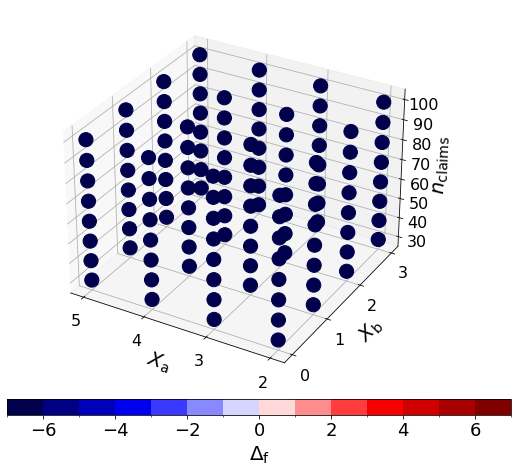

/home/users/lhasbini/.local/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:1111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
/home/users/lhasbini/.local/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:1113: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


<Figure size 432x288 with 0 Axes>

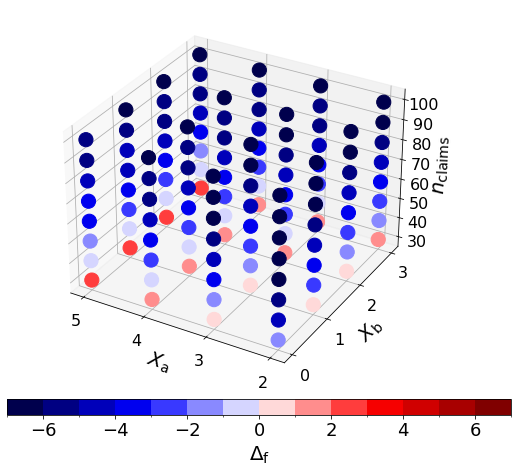

/home/users/lhasbini/.local/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:1111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
/home/users/lhasbini/.local/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:1113: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


<Figure size 432x288 with 0 Axes>

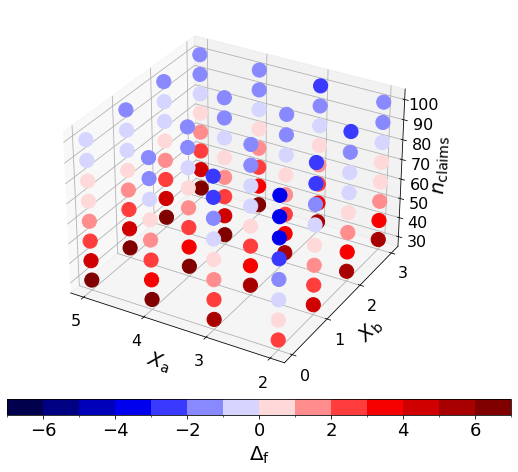

<Figure size 432x288 with 0 Axes>

In [6]:
for height in local_height :
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    cmap = 'seismic'
    bounds = np.arange(-7, 8)
    norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=plt.get_cmap(cmap).N)

    # Scatter plot with color mapping based on frequency_diff
    sc = ax.scatter(performances[height]['Xa'], performances[height]['Xb'], performances[height]['min_claims'], np.arange(-7, 8, 1),
                    c=performances[height]['frequency_diff'], cmap=cmap, norm=norm, marker='o', s=200, depthshade=0)

    # Labels
    ax.set_xlabel(r"$X_{\mathrm{a}}$", fontsize=20)
    ax.set_xticks(performances[height]['Xa'].unique())
    ax.set_ylabel(r"$X_{\mathrm{b}}$", fontsize=20)
    ax.set_yticks(performances[height]['Xb'].unique())
    ax.set_zlabel(r"$n_{\mathrm{claims}}$", fontsize=20)
    ax.set_zticks(performances[height]['min_claims'].unique())
    ax.tick_params(axis='both', which='major', labelsize=16)

    #Invert axis 
    ax.invert_xaxis()

    #Colormap
    cbar_ax = fig.add_axes([0.2, 0.07, 0.7, 0.03])  # Adjust position for second-row colorbar
    cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal', label='Correlation')
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label(r"$\Delta_{\mathrm{f}}$", fontsize=20)

    plt.show()
    plt.tight_layout()
    fig.savefig(path_save_fig+"perf_local-height-"+str(height)+"_1998-2024_frequency_diff", transparent=True, bbox_inches='tight', dpi=300)
    fig.savefig(path_save_fig+"perf_local-height-"+str(height)+"_1998-2024_frequency_diff.svg", format="svg", bbox_inches="tight", dpi=300, transparent=True)
    fig.savefig(path_save_fig+"perf_local-height-"+str(height)+"_1998-2024_frequency_diff.pdf", format="pdf", bbox_inches="tight", dpi=300, transparent=True)

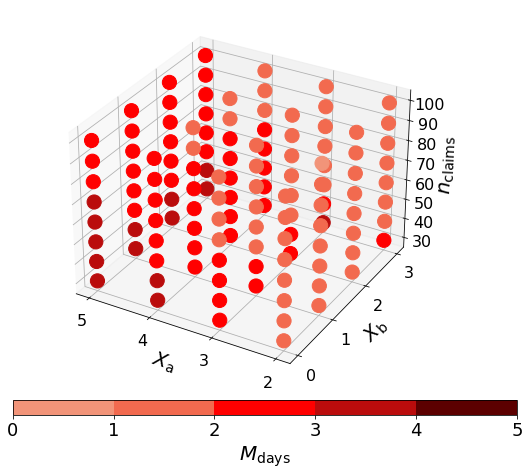

<Figure size 432x288 with 0 Axes>

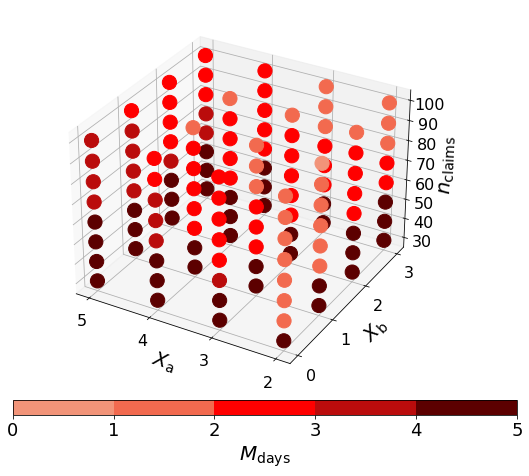

<Figure size 432x288 with 0 Axes>

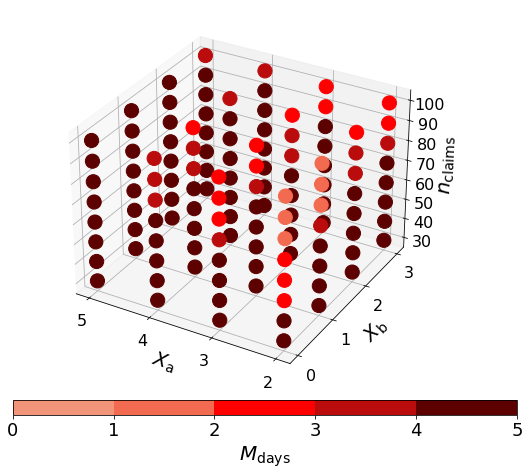

<Figure size 432x288 with 0 Axes>

In [7]:
for height in local_height :
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    hex_colors = ["#5c0000","#ba0c0c","#ff0000", "#f26a4f", "#f29479"]
    cmap = mcolors.ListedColormap(list(reversed(hex_colors)), name="custom_cmap")

    bounds = np.arange(0, 6)  # Define discrete levels
    norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=plt.get_cmap(cmap).N)

    # Scatter plot with color mapping based on frequency_diff
    sc = ax.scatter(performances[height]['Xa'], performances[height]['Xb'], performances[height]['min_claims'], 
                    c=performances[height]['max_days_diff'], cmap=cmap, norm=norm, marker='o', s=200, depthshade=0)

    # Labels
    ax.set_xlabel(r"$X_{\mathrm{a}}$", fontsize=20)
    ax.set_xticks(performances[height]['Xa'].unique())
    ax.set_ylabel(r"$X_{\mathrm{b}}$", fontsize=20)
    ax.set_yticks(performances[height]['Xb'].unique())
    ax.set_zlabel(r"$n_{\mathrm{claims}}$", fontsize=20)
    ax.set_zticks(performances[height]['min_claims'].unique())
    ax.tick_params(axis='both', which='major', labelsize=16)

    #Invert axis 
    ax.invert_xaxis()

    #Colormap
    cbar_ax = fig.add_axes([0.2, 0.07, 0.7, 0.03])  # Adjust position for second-row colorbar
    cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal', label='Correlation')
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label(r"$M_{\mathrm{days}}$", fontsize=20)

    plt.show()
    plt.tight_layout()
    fig.savefig(path_save_fig+"perf_local-height-"+str(height)+"_1998-2024_max_days_diff", transparent=True, bbox_inches='tight', dpi=300)
    fig.savefig(path_save_fig+"perf_local-height-"+str(height)+"_1998-2024_max_days_diff.svg", format="svg", bbox_inches="tight", dpi=300, transparent=True)
    fig.savefig(path_save_fig+"perf_local-height-"+str(height)+"_1998-2024_max_days_diff.pdf", format="pdf", bbox_inches="tight", dpi=300, transparent=True)

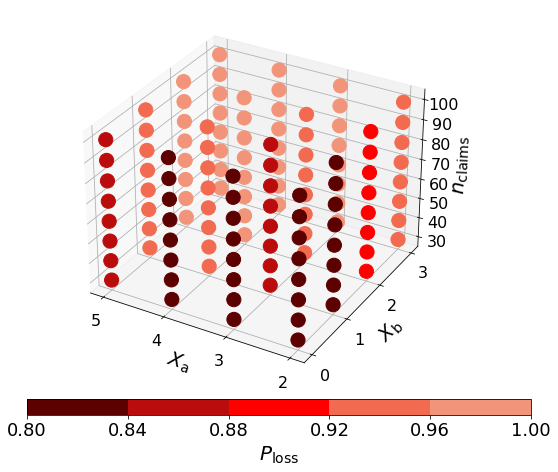

<Figure size 432x288 with 0 Axes>

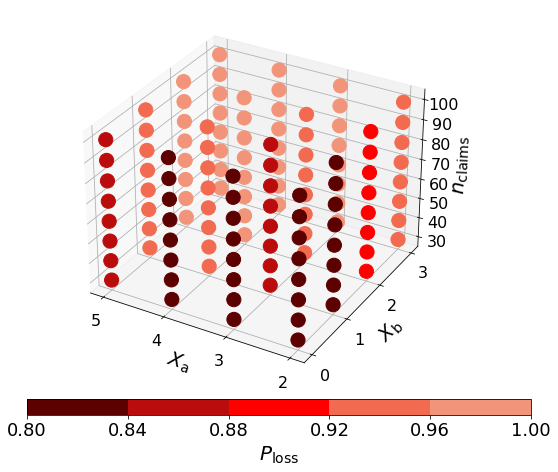

<Figure size 432x288 with 0 Axes>

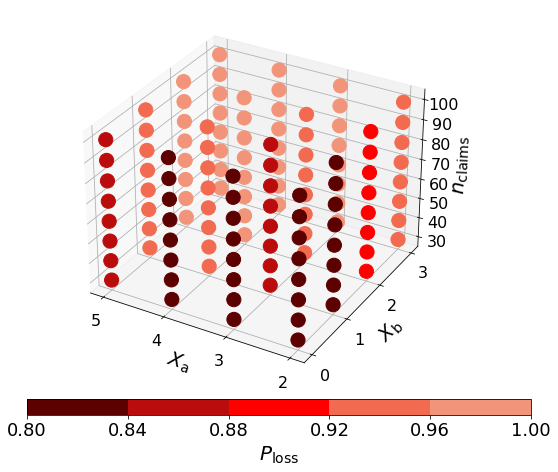

<Figure size 432x288 with 0 Axes>

In [8]:
for height in local_height :
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    hex_colors = ["#5c0000","#ba0c0c","#ff0000", "#f26a4f", "#f29479"]#, "#fedfd4"]
    cmap = mcolors.ListedColormap(hex_colors, name="custom_cmap")

    bounds = np.linspace(0.8, 1, 6)  # Define discrete levels
    norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=plt.get_cmap(cmap).N)

    # Scatter plot with color mapping based on frequency_diff
    sc = ax.scatter(performances[height]['Xa'], performances[height]['Xb'], performances[height]['min_claims'], 
                    c=performances[height]['percentage_loss'], cmap=cmap, norm=norm, marker='o', s=200, depthshade=0)

    # Labels
    ax.set_xlabel(r"$X_{\mathrm{a}}$", fontsize=20)
    ax.set_xticks(performances[height]['Xa'].unique())
    ax.set_ylabel(r"$X_{\mathrm{b}}$", fontsize=20)
    ax.set_yticks(performances[height]['Xb'].unique())
    ax.set_zlabel(r"$n_{\mathrm{claims}}$", fontsize=20)
    ax.set_zticks(performances[height]['min_claims'].unique())
    ax.tick_params(axis='both', which='major', labelsize=16)

    #Invert axis 
    ax.invert_xaxis()

    #Colormap
    cbar_ax = fig.add_axes([0.2, 0.07, 0.7, 0.03])  # Adjust position for second-row colorbar
    cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal', label='Correlation')
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label(r"$P_{\mathrm{loss}}$", fontsize=20)

    plt.show()
    plt.tight_layout()
    fig.savefig(path_save_fig+"perf_local-height-"+str(height)+"_1998-2024_percentage_loss", transparent=True, bbox_inches='tight', dpi=300)
    fig.savefig(path_save_fig+"perf_local-height-"+str(height)+"_1998-2024_percentage_loss.svg", format="svg", bbox_inches="tight", dpi=300, transparent=True)
    fig.savefig(path_save_fig+"perf_local-height-"+str(height)+"_1998-2024_percentage_loss.pdf", format="pdf", bbox_inches="tight", dpi=300, transparent=True)

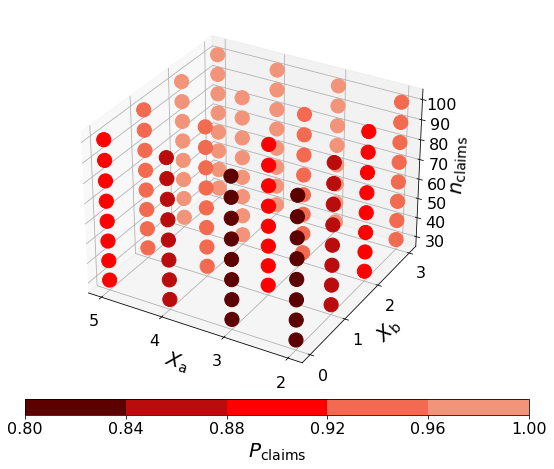

<Figure size 432x288 with 0 Axes>

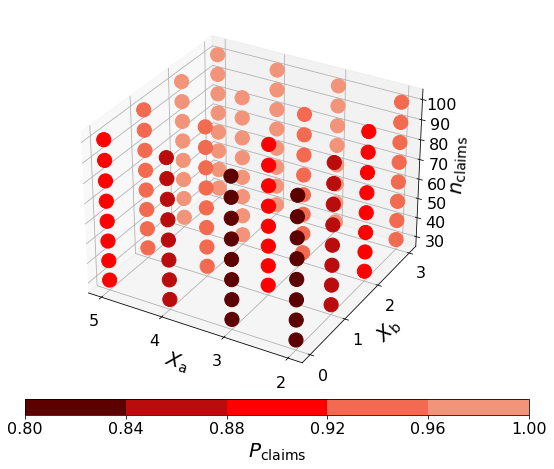

<Figure size 432x288 with 0 Axes>

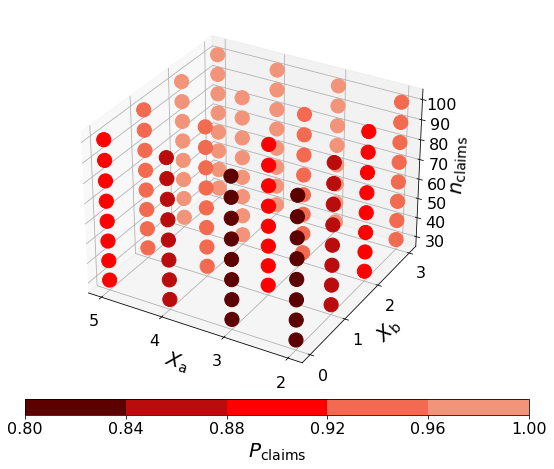

<Figure size 432x288 with 0 Axes>

In [9]:
for height in local_height :
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    hex_colors = ["#5c0000","#ba0c0c","#ff0000", "#f26a4f", "#f29479"]#, "#fedfd4"]
    cmap = mcolors.ListedColormap(hex_colors, name="custom_cmap")

    bounds = np.linspace(0.8, 1, 6)  # Define discrete levels
    norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=plt.get_cmap(cmap).N)

    # Scatter plot with color mapping based on frequency_diff
    sc = ax.scatter(performances[height]['Xa'], performances[height]['Xb'], performances[height]['min_claims'], 
                    c=performances[height]['percentage_claims'], cmap=cmap, norm=norm, marker='o', s=200, depthshade=0)

    # Labels
    ax.set_xlabel(r"$X_{\mathrm{a}}$", fontsize=20)
    ax.set_xticks(performances[height]['Xa'].unique())
    ax.set_ylabel(r"$X_{\mathrm{b}}$", fontsize=20)
    ax.set_yticks(performances[height]['Xb'].unique())
    ax.set_zlabel(r"$n_{\mathrm{claims}}$", fontsize=20)
    ax.set_zticks(performances[height]['min_claims'].unique())
    ax.tick_params(axis='both', which='major', labelsize=16)

    #Invert axis 
    ax.invert_xaxis()

    #Colormap
    cbar_ax = fig.add_axes([0.2, 0.07, 0.7, 0.03])  # Adjust position for second-row colorbar
    cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal', label='Correlation')
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label(r"$P_{\mathrm{claims}}$", fontsize=20)

    plt.show()
    plt.tight_layout()
    fig.savefig(path_save_fig+"perf_local-height-"+str(height)+"_1998-2024_percentage_claims", transparent=True, bbox_inches='tight', dpi=300)
    fig.savefig(path_save_fig+"perf_local-height-"+str(height)+"_1998-2024_percentage_claims.svg", format="svg", bbox_inches="tight", dpi=300, transparent=True)
    fig.savefig(path_save_fig+"perf_local-height-"+str(height)+"_1998-2024_percentage_claims.pdf", format="pdf", bbox_inches="tight", dpi=300, transparent=True)

/home/users/lhasbini/.local/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:1111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
/home/users/lhasbini/.local/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:1113: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


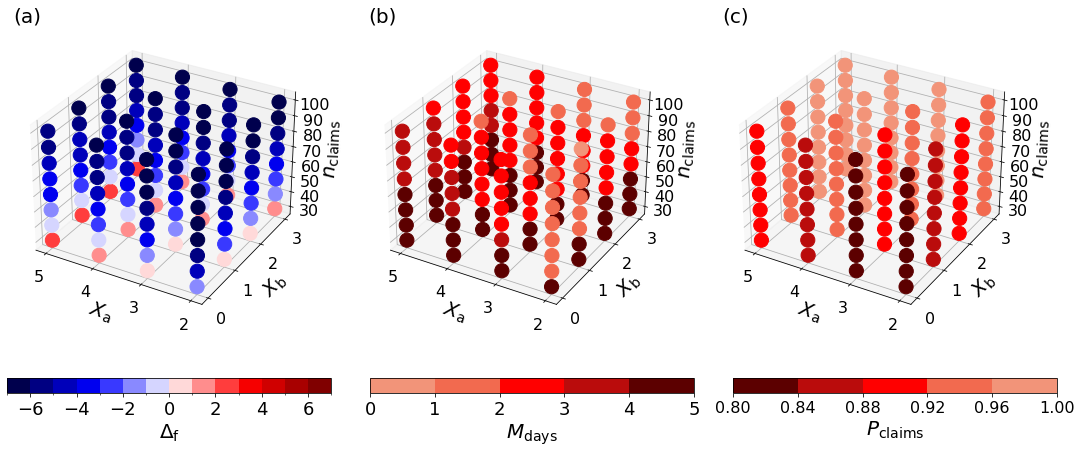

<Figure size 432x288 with 0 Axes>

In [10]:
### COMBINE THE 3 PLOTS INTO ONE 

height = 10
fig = plt.figure(figsize=(18, 7))


########## FREQUENCY DIFF #############
ax1 = fig.add_subplot(131, projection='3d')

cmap = 'seismic'
bounds = np.arange(-7, 8)
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=plt.get_cmap(cmap).N)

# Scatter plot with color mapping based on frequency_diff
sc = ax1.scatter(performances[height]['Xa'], performances[height]['Xb'], performances[height]['min_claims'], np.arange(-7, 8, 1),
                c=performances[height]['frequency_diff'], cmap=cmap, norm=norm, marker='o', s=200, depthshade=0)

# sc.set_edgecolors = sc.set_facecolors = lambda *args:None

# Labels
ax1.set_xlabel(r"$X_{\mathrm{a}}$", fontsize=20)
ax1.set_xticks(performances[height]['Xa'].unique())
ax1.set_ylabel(r"$X_{\mathrm{b}}$", fontsize=20)
ax1.set_yticks(performances[height]['Xb'].unique())
ax1.set_zlabel(r"$n_{\mathrm{claims}}$", fontsize=20)
ax1.set_zticks(performances[height]['min_claims'].unique())
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.set_title("(a)", loc="left", fontsize=20)

#Invert axis 
ax1.invert_xaxis()

#Colormap
cbar_ax = fig.add_axes([0.12, 0.07, 0.25, 0.03])  # Adjust position for second-row colorbar
cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal', label='Correlation')
cbar.ax.tick_params(labelsize=18)
cbar.set_label(r"$\Delta_{\mathrm{f}}$", fontsize=20)

########## NB MAX DAYS DIFF #############
ax2 = fig.add_subplot(132, projection='3d')

# cmap = 'seismic'
# hex_colors = ["#220901", "#621708", "#941b0c", "#bc3908", "#f6aa1c"]
# hex_colors = ["#5c0000","#751717","#ba0c0c","#ff0000","#f29479"]
hex_colors = ["#5c0000","#ba0c0c","#ff0000", "#f26a4f", "#f29479"]
cmap = mcolors.ListedColormap(list(reversed(hex_colors)), name="custom_cmap")

# hex_colors = ["#f29479","#f26a4f","#ef3c2d","#cb1b16","#65010c"]
# cmap = mcolors.ListedColormap(hex_colors, name="custom_cmap")

bounds = np.arange(0, 6)  # Define discrete levels
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=plt.get_cmap(cmap).N)

# Scatter plot with color mapping based on frequency_diff
sc = ax2.scatter(performances[height]['Xa'], performances[height]['Xb'], performances[height]['min_claims'], 
                c=performances[height]['max_days_diff'], cmap=cmap, norm=norm, marker='o', s=200, depthshade=0)

# Labels
ax2.set_xlabel(r"$X_{\mathrm{a}}$", fontsize=20)
ax2.set_xticks(performances[height]['Xa'].unique())
ax2.set_ylabel(r"$X_{\mathrm{b}}$", fontsize=20)
ax2.set_yticks(performances[height]['Xb'].unique())
ax2.set_zlabel(r"$n_{\mathrm{claims}}$", fontsize=20)
ax2.set_zticks(performances[height]['min_claims'].unique())
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.set_title("(b)", loc="left", fontsize=20)

#Invert axis 
ax2.invert_xaxis()

#Colormap
cbar_ax = fig.add_axes([0.4, 0.07, 0.25, 0.03])  # Adjust position for second-row colorbar
cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal', label='Correlation')
cbar.ax.tick_params(labelsize=18)
cbar.set_label(r"$M_{\mathrm{days}}$", fontsize=20)

########## PERCENTAGE OF CLAIMS #############
ax3 = fig.add_subplot(133, projection='3d')

hex_colors = ["#5c0000","#ba0c0c","#ff0000", "#f26a4f", "#f29479"]#, "#fedfd4"]
cmap = mcolors.ListedColormap(hex_colors, name="custom_cmap")
bounds = np.linspace(0.8, 1, 6)  # Define discrete levels
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=plt.get_cmap(cmap).N)

# Scatter plot with color mapping based on frequency_diff
sc = ax3.scatter(performances[height]['Xa'], performances[height]['Xb'], performances[height]['min_claims'], 
                c=performances[height]['percentage_claims'], cmap=cmap, norm=norm, marker='o', s=200, depthshade=0)

# Labels
ax3.set_xlabel(r"$X_{\mathrm{a}}$", fontsize=20)
ax3.set_xticks(performances[height]['Xa'].unique())
ax3.set_ylabel(r"$X_{\mathrm{b}}$", fontsize=20)
ax3.set_yticks(performances[height]['Xb'].unique())
ax3.set_zlabel(r"$n_{\mathrm{claims}}$", fontsize=20)
ax3.set_zticks(performances[height]['min_claims'].unique())
ax3.tick_params(axis='both', which='major', labelsize=16)
ax3.set_title("(c)", loc="left", fontsize=20)

#Invert axis 
ax3.invert_xaxis()

#Colormap
cbar_ax = fig.add_axes([0.68, 0.07, 0.25, 0.03])  # Adjust position for second-row colorbar
cbar = fig.colorbar(sc, cax=cbar_ax, orientation='horizontal', label='Correlation')
cbar.ax.tick_params(labelsize=16)
cbar.set_label(r"$P_{\mathrm{claims}}$", fontsize=20)

plt.show()
plt.tight_layout()
fig.savefig(path_save_fig+"perf_local-height-"+str(height)+"_1998-2024_all_metrics", transparent=True, bbox_inches='tight', dpi=300)
fig.savefig(path_save_fig+"perf_local-height-"+str(height)+"_1998-2024_all_metrics.svg", format="svg", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig(path_save_fig+"perf_local-height-"+str(height)+"_1998-2024_all_metrics.pdf", format="pdf", bbox_inches="tight", dpi=300, transparent=True)

# Optimization the windows

In [11]:
# Normalize objectives using min-max scaling
def normalize(series):
    # For min-max scaling to [0, 1] range
    return (series - series.min()) / (series.max() - series.min())

for height in local_height :
    performances[height]['norm_frequency_diff'] = normalize(np.abs(performances[height]['frequency_diff']))  # Closer to 0 is better
    performances[height]['norm_max_days_diff'] = normalize(np.abs(performances[height]['max_days_diff']))  # Minimize
    # performances['norm_percentage_claims'] = normalize(performances['percentage_claims'])  # Maximize (negate in objective)

def objective_with_weights(row, weight_freq, weight_days, weight_claims) : 
    return np.sqrt(weight_freq * row['norm_frequency_diff']**2 + 
        weight_days * row['norm_max_days_diff']**2)

In [12]:
# Make 3 plots of the optimal value of the parameters as the function of varying weigths 
height = 10
weights_freq = np.arange(0.1, 1, 0.1)
weight_claims = 0
# weights_days = np.arange(0.2, 0.9, 0.1)

df_Xa_opt = pd.DataFrame(columns=weights_freq)#, index=weights_freq)
df_Xb_opt = pd.DataFrame(columns=weights_freq)#, index=weights_freq)
df_nb_opt = pd.DataFrame(columns=weights_freq)#, index=weights_freq)

for weight_freq in weights_freq :
    weight_days = 1 - weight_freq
        
    performances[height]['objective_value'] = performances[height].apply(objective_with_weights, args=(weight_freq, weight_days, weight_claims), axis=1)

    # Find the row with the minimum objective value
    best_row = performances[height].loc[performances[height]['objective_value'].idxmin()]

    # Extract optimized values
    Xa_opt = best_row['Xa']
    Xb_opt = best_row['Xb']
    nb_opt = best_row['min_claims']
    
    df_Xa_opt.loc[0, weight_freq] = Xa_opt
    df_Xb_opt.loc[0, weight_freq] = Xb_opt
    df_nb_opt.loc[0, weight_freq] = nb_opt

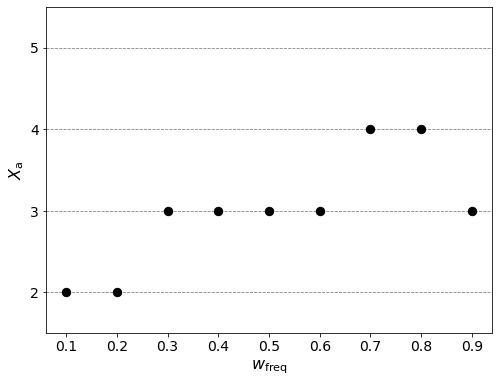

In [13]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(df_Xa_opt.columns, df_Xa_opt.loc[0], s=70, color="black")
plt.ylabel(r"$X_{\mathrm{a}}$", fontsize=16)
plt.ylim(1.5, 5.5)
plt.yticks(
    ticks=np.arange(2, 6),
    labels=np.arange(2, 6),
    rotation=0,
    fontsize=14
)
plt.xlabel(r"$w_{\mathrm{freq}}$", fontsize=16)
plt.xticks(
    ticks=np.arange(0.1, 1, 0.1),
    labels=['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9'],
    rotation=0,
    fontsize=14
)
plt.grid(which='major', axis='y', linestyle='--', color='black', alpha=0.5)
plt.show()

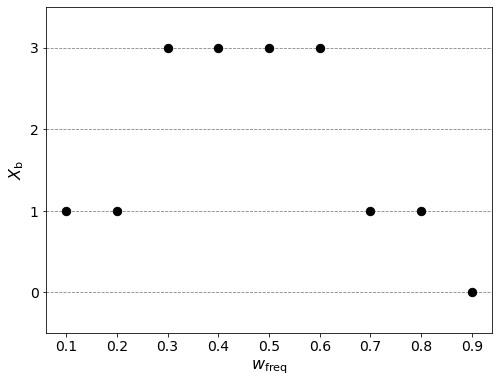

In [14]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(df_Xb_opt.columns, df_Xb_opt.loc[0], s=70, color="black")
plt.ylabel(r"$X_{\mathrm{b}}$", fontsize=16)
plt.ylim(-0.5, 3.5)
plt.yticks(
    ticks=np.arange(0, 4),
    labels=np.arange(0, 4),
    rotation=0,
    fontsize=14
)
plt.xlabel(r"$w_{\mathrm{freq}}$", fontsize=16)
plt.xticks(
    ticks=np.arange(0.1, 1, 0.1),
    labels=['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9'],
    rotation=0,
    fontsize=14
)
plt.grid(which='major', axis='y', linestyle='--', color='black', alpha=0.5)
plt.show()

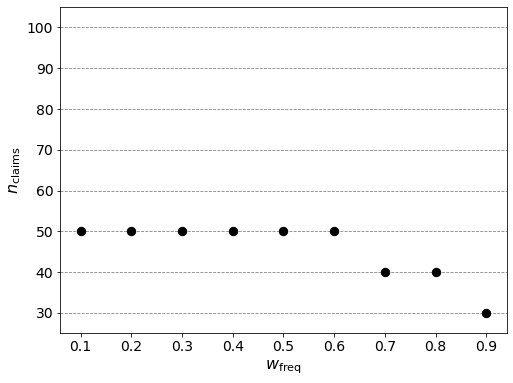

In [15]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(df_nb_opt.columns, df_nb_opt.loc[0], s=70, color="black")
plt.ylabel(r"$n_{\mathrm{claims}}$", fontsize=16)
plt.ylim(25, 105)
plt.yticks(
    ticks=np.arange(30, 110, 10),
    labels=np.arange(30, 110, 10),
    rotation=0,
    fontsize=14
)
plt.xlabel(r"$w_{\mathrm{freq}}$", fontsize=16)
plt.xticks(
    ticks=np.arange(0.1, 1, 0.1),
    labels=['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9'],
    rotation=0,
    fontsize=14
)
plt.grid(which='major', axis='y', linestyle='--', color='black', alpha=0.5)
plt.show()

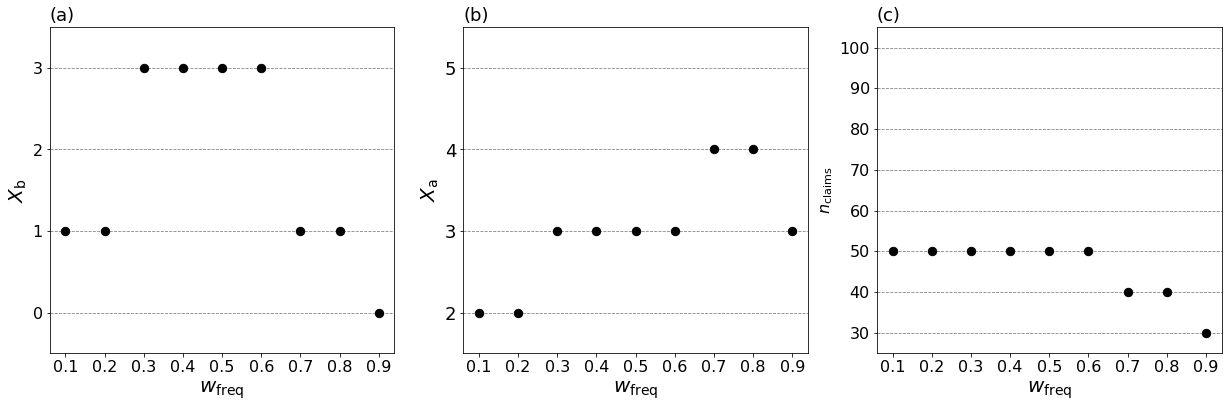

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(21, 6))

############## XB #################
ax[0].scatter(df_Xb_opt.columns, df_Xb_opt.loc[0], s=70, color='black')
ax[0].set_ylabel(r"$X_{\mathrm{b}}$", fontsize=20)
ax[0].set_ylim(-0.5, 3.5)
ax[0].set_yticks(
    ticks=np.arange(0, 4),
    labels=np.arange(0, 4),
    rotation=0,
    fontsize=14
)
ax[0].grid(which='major', axis='y', linestyle='--', color='black', alpha=0.5)
ax[0].tick_params(axis='both', which='major', labelsize=16)
ax[0].set_title('(a)', loc='left', fontsize=18)

############## XA #################
ax[1].scatter(df_Xa_opt.columns, df_Xa_opt.loc[0], s=70, color='black')
ax[1].set_ylabel(r"$X_{\mathrm{a}}$", fontsize=20)
ax[1].set_ylim(1.5, 5.5)
ax[1].set_yticks(
    ticks=np.arange(2, 6),
    labels=np.arange(2, 6),
    rotation=0,
    fontsize=14
)
ax[1].grid(which='major', axis='y', linestyle='--', color='black', alpha=0.5)
ax[1].tick_params(axis='both', which='major', labelsize=18)
ax[1].set_title('(b)', loc='left', fontsize=18)

############## NB MIN CLAIMS #################
ax[2].scatter(df_nb_opt.columns, df_nb_opt.loc[0], s=70, color='black')
ax[2].set_ylabel(r"$n_{\mathrm{claims}}$", fontsize=16)
ax[2].set_ylim(25, 105)
ax[2].set_yticks(
    ticks=np.arange(30, 110, 10),
    labels=np.arange(30, 110, 10),
    rotation=0,
    fontsize=14
)
ax[2].grid(which='major', axis='y', linestyle='--', color='black', alpha=0.5)
ax[2].tick_params(axis='both', which='major', labelsize=16)
ax[2].set_title('(c)', loc='left', fontsize=18)

for axi in ax : 
    axi.set_xlabel(r"$w_{\mathrm{freq}}$", fontsize=20)
    axi.set_xticks(
        ticks=np.arange(0.1, 1, 0.1),
        labels=['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9'],
        rotation=0,
        fontsize=16
    )
    
fig.savefig(path_save_fig+"opt-param_with_wfreq_"+str(height)+".png", transparent=True, bbox_inches='tight', dpi=300)
fig.savefig(path_save_fig+"opt-param_with_wfreq_"+str(height)+".svg", format="svg", bbox_inches="tight", dpi=300, transparent=True)
fig.savefig(path_save_fig+"opt-param_with_wfreq_"+str(height)+".pdf", format="pdf", bbox_inches="tight", dpi=300, transparent=True)